#### Setup env and jupyter kernel

In [1]:
!uv run $DATA_ROOT/ml-lab/setup_kernel.py diffusers-lab

Using CPython 3.13.11
Creating virtual environment at: .venv
Resolved 152 packages in 2ms
Prepared 1 package in 11ms                                               
Installed 123 packages in 251ms1.0a20260118                 
 + accelerate==1.13.0.dev0 (from git+https://github.com/huggingface/accelerate@38dadd9537d3cb43e3149964c06a3f011b40aa6d)
 + anyio==4.12.1
 + argon2-cffi==25.1.0
 + argon2-cffi-bindings==25.1.0
 + arrow==1.4.0
 + asttokens==3.0.1
 + async-lru==2.1.0
 + attrs==25.4.0
 + babel==2.17.0
 + beautifulsoup4==4.14.3
 + bleach==6.3.0
 + certifi==2022.12.7
 + cffi==2.0.0
 + charset-normalizer==2.1.1
 + click==8.3.1
 + comm==0.2.3
 + compel==2.3.1
 + debugpy==1.8.19
 + decorator==5.2.1
 + defusedxml==0.7.1
 + diffusers==0.37.0.dev0 (from git+https://github.com/huggingface/diffusers@ec376293714f269947f6d9d8a572bd73040bc1a0)
 + diffusers-lab==0.1.0 (from file:///work/ml-lab/diffusers-lab)
 + executing==2.2.1
 + fastjsonschema==2.21.2
 + filelock==3.19.1
 + fqdn==1.5.1
 + fsspec=

#### SDXL

Initial setup

In [1]:
import os
from IPython.display import display
import torch
from diffusers import StableDiffusionXLPipeline

# Disable MIOpen on gfx1151
if os.environ.get("RUNTIME_TYPE", "") == "rocm-gfx1151":
    torch.backends.cudnn.enabled = False

work_dir = os.environ.get('DATA_ROOT', '/work')
%cd {work_dir}
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

/work


Load models

In [22]:
model = "checkpoints/JANKUTrainedNoobaiRouwei_v60.safetensors"
model_path = f"{work_dir}/models/{model}"

pipeline = StableDiffusionXLPipeline.from_single_file(
    model_path,
    use_safetensors=True,
    disable_mmap=True,
    )
pipeline = pipeline.to("cuda", dtype=torch.float16)
last_seed = 4552815869463591

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

T2I Inferrence

('masterpiece, best quality, amazing quality, 4k, very aesthetic, high resolution, ultra-detailed, absurdres, newest, scenery, 1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, BREAK, depth of field',
 '1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, monochrome, modern, recent, old, oldest, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, long body, lowres, bad anatomy, (bad hands, missing fingers, extra fingers, extra digits, fewer digits:1.2), cropped, very displeasing, (worst quality, bad quality:1.2), sketch, jpeg artifacts, signature, watermark, u

Seed: 4552815869463591


  0%|          | 0/20 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


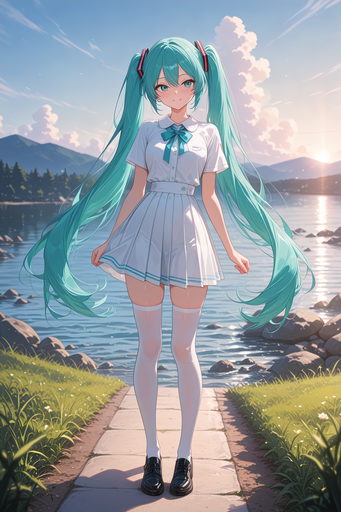

In [24]:
from diffusers import EulerAncestralDiscreteScheduler
from diffusers_lab.prompting import get_il_prompts 
from diffusers_lab.conditioning import get_sdxl_prompt_embeds
from diffusers_lab import preview_image
from typing import Any
from PIL import Image

pos, _, neg, _ = get_il_prompts("""
1girl, solo,
full body, standing,
straight on,
clothed, safe,
looking at viewer, smiling,
hatsune miku,
white shirt, short sleeves
white skirt, pleated skirt, white thighhighs
outdoors, cloud, sky, daytime, wild, grass, lake
black shoes
""", reality=False)
_ = display((pos, neg))

prompt_embeds = get_sdxl_prompt_embeds(pipeline, pos, neg)

pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config,
    use_beta_sigmas = True,
    timestep_spacing = "linspace"
    )
generator = torch.Generator(device="cuda").manual_seed(last_seed)
#last_seed = generator.seed() # uncomment to randomize
print(f"Seed: {last_seed}")
params: dict[str, Any] = dict(
    num_inference_steps = 20,
    guidance_scale = 2.5,
    width = 1024,
    height = 1536
)
params.update(prompt_embeds)
params["generator"] = generator

image = pipeline(**params)[0][0] # pyright: ignore[reportOptionalSubscript, reportIndexIssue]
assert isinstance(image, Image.Image)


preview_image(image) # pyright: ignore[reportArgumentType]


Detailer: Segmenting using prompt 'face, eyes'
Detailer: Segmented 0.8271484375 @ [463.5, 194.625, 584.5, 329.5]
Detailer: Segmented 1 masks
Detailer: Processing mask with bbox [466.0, 197.0, 583.0, 329.0]
Detailer: Expanded context bbox to (437, 164, 612, 362)
Detailer: Force ratio 1, final bbox: (437, 176, 612, 351)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (437, 176, 612, 351)


  0%|          | 0/8 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl_inpaint.py:1001: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


Detailer: Finished mask with bbox (437, 176, 612, 351)


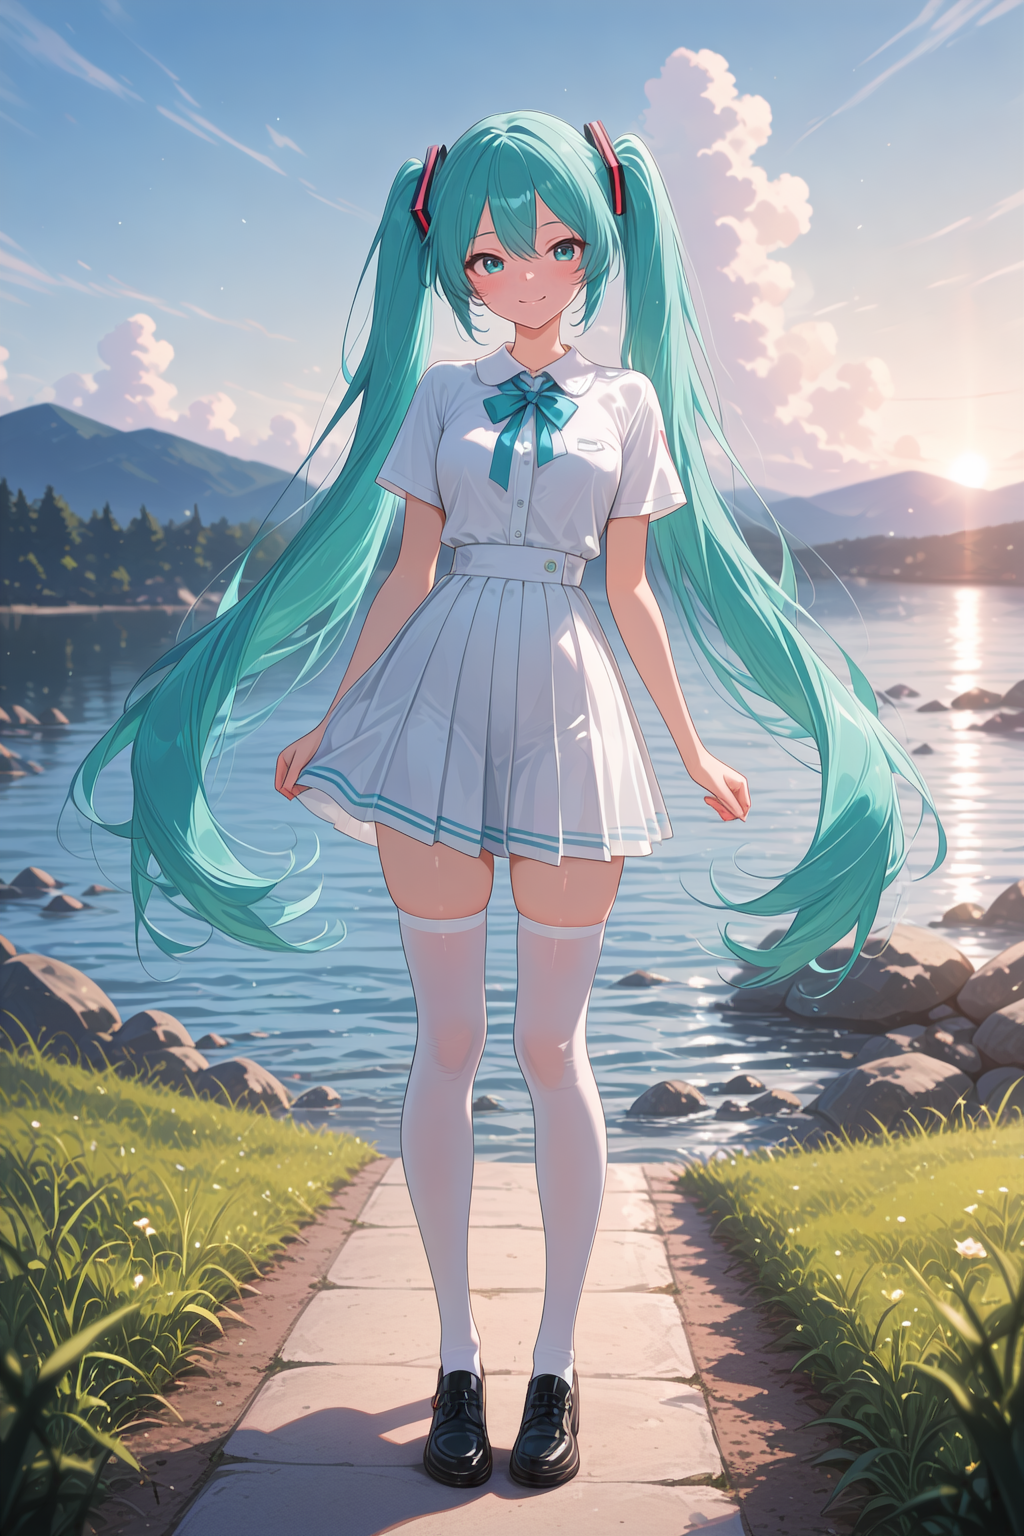

In [25]:
from diffusers_lab.detailer import SDXLDetailer

face_detailer = SDXLDetailer(pipeline, "face, eyes")

detailed = face_detailer(image, pos, neg, force_patch_ratio=1)
detailed

Detailer: Segmenting using prompt 'hands'
Detailer: Segmented 0.79296875 @ [686.0, 751.0, 750.0, 823.0]
Detailer: Segmented 0.81103515625 @ [274.5, 725.5, 325.5, 801.0]
Detailer: Segmented 2 masks


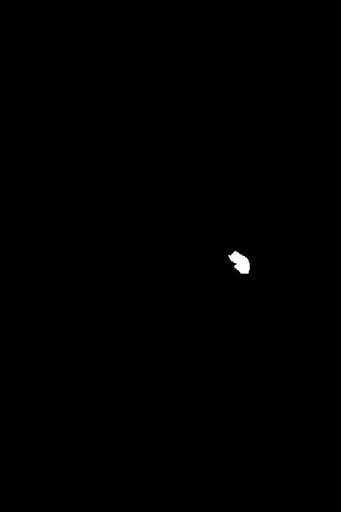

Detailer: Processing mask with bbox [686.0, 753.0, 749.0, 820.0]
Detailer: Expanded context bbox to (655, 720, 780, 853)
Detailer: Force ratio 1, final bbox: (655, 724, 780, 849)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (655, 724, 780, 849)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (655, 724, 780, 849)


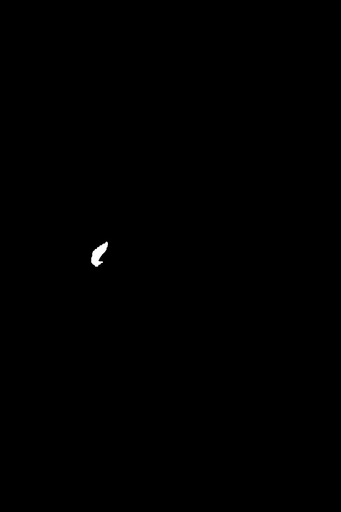

Detailer: Processing mask with bbox [274.0, 725.0, 323.0, 799.0]
Detailer: Expanded context bbox to (250, 688, 347, 836)
Detailer: Force ratio 1, final bbox: (250, 714, 347, 811)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (250, 714, 347, 811)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (250, 714, 347, 811)


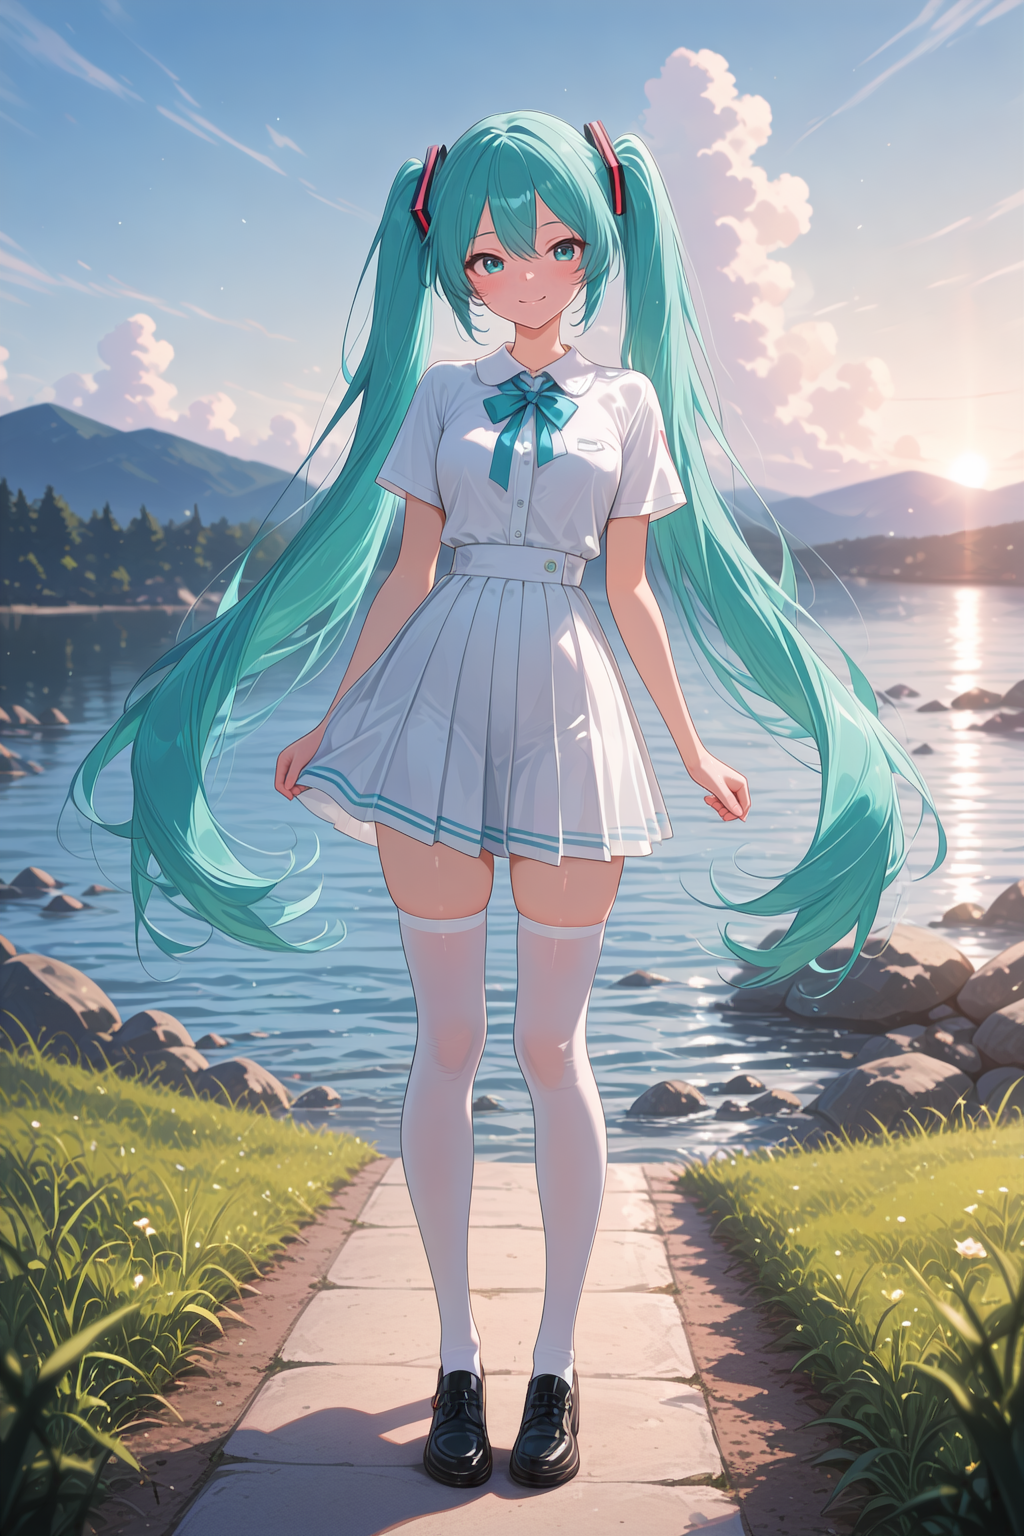

In [ ]:
hand_detailer = SDXLDetailer(pipeline, "hands")

detailed = hand_detailer(detailed, pos, neg,
    context_ratio=0.5, force_patch_ratio=1, preview_mask=True)
_ = display(detailed)

Detailer: Segmenting using prompt 'shoe'
Detailer: Segmented 0.95703125 @ [422.5, 1366.0, 492.5, 1486.0]
Detailer: Segmented 0.958984375 @ [508.0, 1370.0, 580.0, 1487.0]
Detailer: Segmented 2 masks
Detailer: Merging all masks


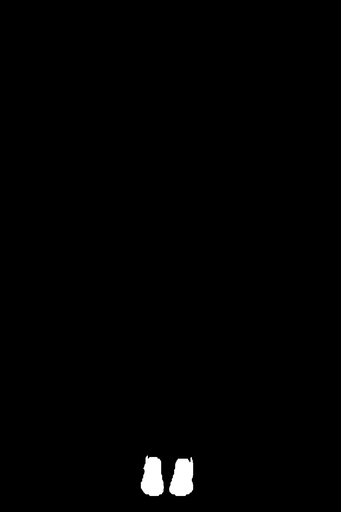

Detailer: Processing mask with bbox [423.0, 1366.0, 579.0, 1487.0]
Detailer: Expanded context bbox to (384, 1336, 618, 1517)
Detailer: Force ratio 1, final bbox: (411, 1336, 592, 1517)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (411, 1336, 592, 1517)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (411, 1336, 592, 1517)


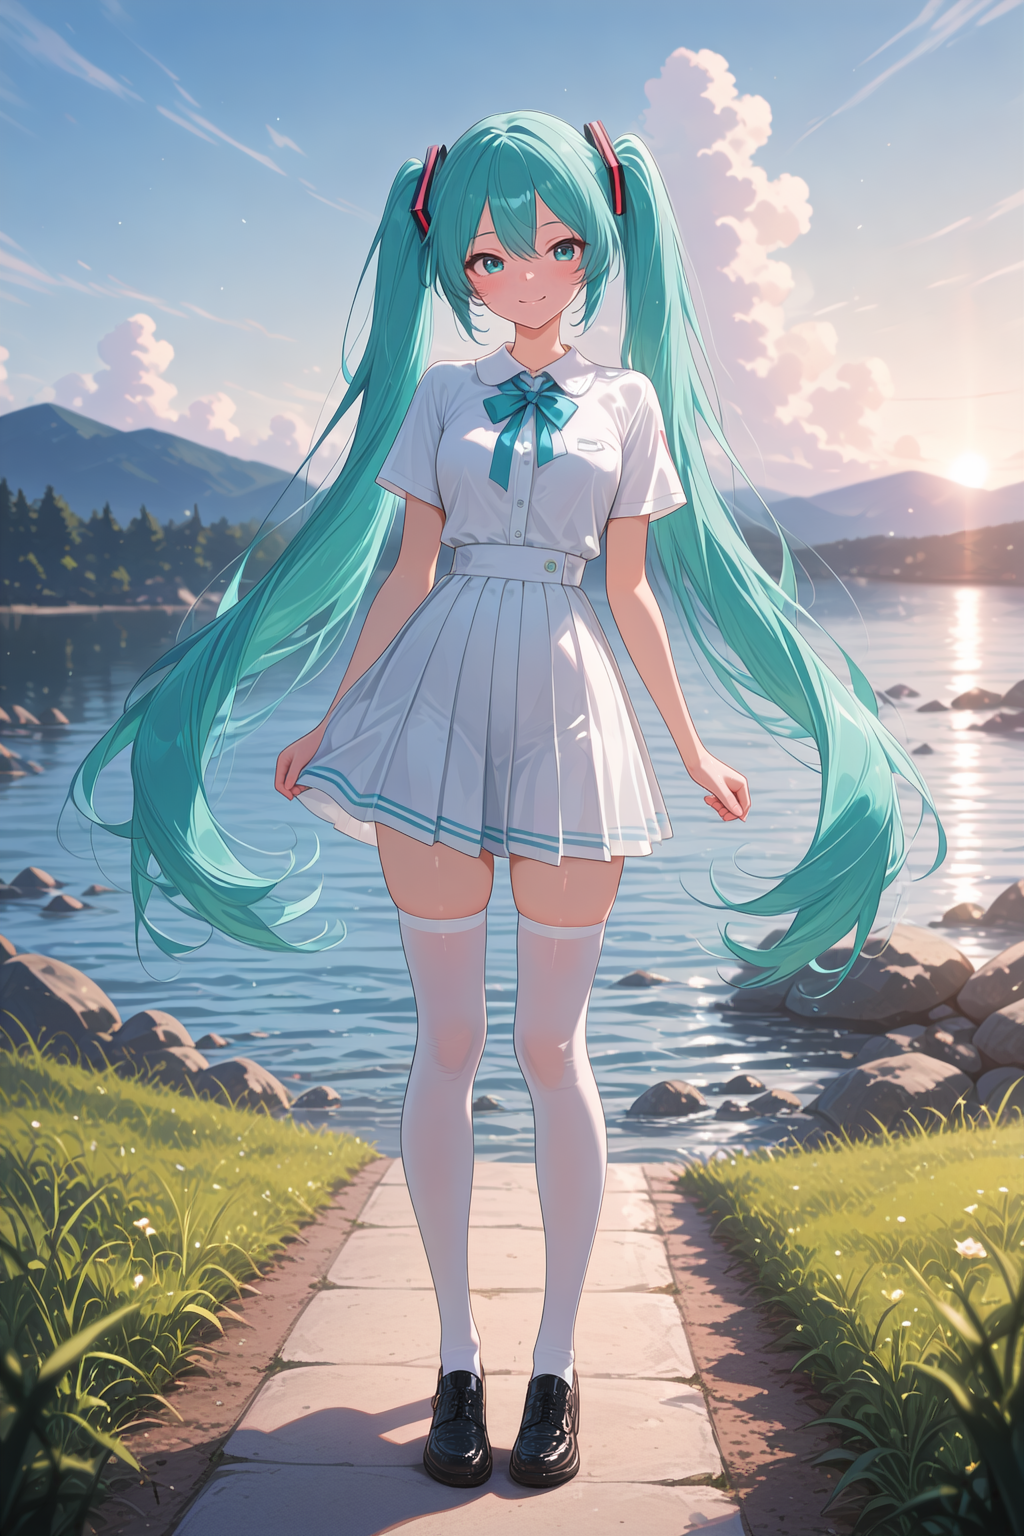

In [27]:
detailer = SDXLDetailer(pipeline, "shoe")

detailed = detailer(detailed, pos, neg,
    merge_mask=True, force_patch_ratio=1, preview_mask=True)
_ = display(detailed)